<a href="https://colab.research.google.com/github/lasith54/Stock-Price-Predictor/blob/main/StockPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn

In [374]:
df = pd.read_csv('AMZN.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6808,2024-06-05,180.100006,181.500000,178.750000,181.279999,181.279999,32116400
6809,2024-06-06,181.750000,185.000000,181.490005,185.000000,185.000000,31371200
6810,2024-06-07,184.899994,186.289993,183.360001,184.300003,184.300003,28021500
6811,2024-06-10,184.070007,187.229996,183.789993,187.059998,187.059998,34445600


In [375]:
df.shape

(6813, 7)

In [376]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [377]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [378]:
train_dates = pd.to_datetime(df['Date'])

In [379]:
cols = list(df)[1:6]
cols

['Open', 'High', 'Low', 'Close', 'Adj Close']

<Axes: >

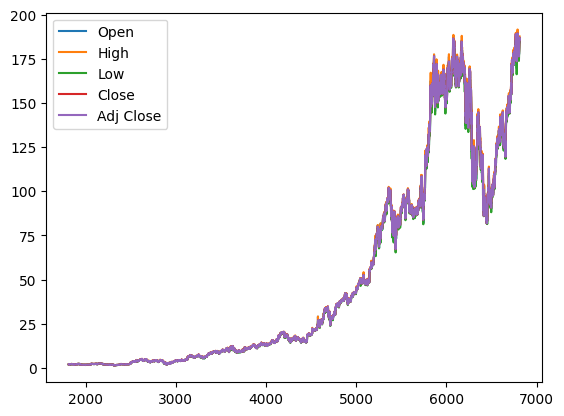

In [380]:
df_for_training = df[cols].astype(float)

df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()

In [381]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_scaled = scaler.transform(df_for_training)


In [382]:
X = []
y = []

In [383]:
n_future = 1
n_past = 45

In [384]:
for i in range(n_past, len(df_scaled)-n_future+1):
  X.append(df_scaled[i-n_past:i, 0:df_for_training.shape[1]])
  y.append(df_scaled[i+n_future-1:i+n_future, 0])

X, y = np.array(X), np.array(y)

In [385]:
print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))

X shape == (6768, 45, 5).
y shape == (6768, 1).


In [386]:
X.shape

(6768, 45, 5)

In [387]:
X_train = X[:int(len(X)*0.8)]
X_test = X[int(len(X)*0.8):]

y_train = y[:int(len(y)*0.8)]
y_test = y[int(len(y)*0.8):]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5414, 45, 5), (1354, 45, 5), (5414, 1), (1354, 1))

In [388]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5414, 45, 5]),
 torch.Size([1354, 45, 5]),
 torch.Size([5414, 1]),
 torch.Size([1354, 1]))

In [389]:
from torch.utils.data import Dataset, DataLoader

class StockPriceDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = StockPriceDataset(X_train, y_train)
test_dataset = StockPriceDataset(X_test, y_test)

In [390]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [391]:
for _, batch in enumerate(train_loader):
  x_batch, y_batch = batch[0].to(device), batch[1].to(device)
  print(x_batch.shape, y_batch.shape)
  break

torch.Size([100, 45, 5]) torch.Size([100, 1])


In [392]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

model = LSTM(5, 150, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(5, 150, num_layers=2, batch_first=True)
  (fc): Linear(in_features=150, out_features=1, bias=True)
)

In [393]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch+1}')
  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 20 == 1:
      avg_loss_across_batches = running_loss / 100
      print('Batch {0}, Loss: {1:.8f}'.format(batch_index+1, avg_loss_across_batches))
      running_loss = 0.0

  print()

In [394]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val loss: {0:.4f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [395]:
learning_rate = 0.01
num_epochs = 225
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  train_one_epoch()
  validate_one_epoch()

Epoch: 1
Batch 2, Loss: 0.00505486
Batch 22, Loss: 0.01921449
Batch 42, Loss: 0.00124541

Val loss: 0.0757
***************************************************

Epoch: 2
Batch 2, Loss: 0.00000487
Batch 22, Loss: 0.00006650
Batch 42, Loss: 0.00003723

Val loss: 0.0393
***************************************************

Epoch: 3
Batch 2, Loss: 0.00001373
Batch 22, Loss: 0.00011008
Batch 42, Loss: 0.00005740

Val loss: 0.0544
***************************************************

Epoch: 4
Batch 2, Loss: 0.00000234
Batch 22, Loss: 0.00002181
Batch 42, Loss: 0.00002299

Val loss: 0.0451
***************************************************

Epoch: 5
Batch 2, Loss: 0.00000169
Batch 22, Loss: 0.00001792
Batch 42, Loss: 0.00003355

Val loss: 0.0341
***************************************************

Epoch: 6
Batch 2, Loss: 0.00000682
Batch 22, Loss: 0.00005176
Batch 42, Loss: 0.00003787

Val loss: 0.0571
***************************************************

Epoch: 7
Batch 2, Loss: 0.00000185
Batch

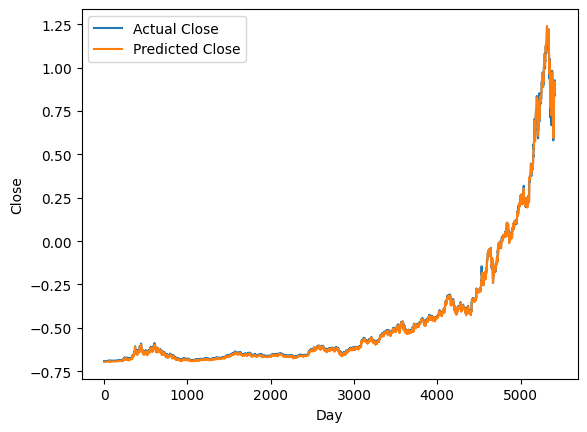

In [396]:
with torch.no_grad():
  predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [397]:
train_predictions = predicted.flatten()
train_predictions.shape

(5414,)

In [398]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 5))
dummies[:, 0] = train_predictions
train_predictions = scaler.inverse_transform(dummies)[:,0]

#train_predictions = dc(dummies[:, 0])
train_predictions

array([-0.15207763, -0.14810458, -0.15270727, ..., 85.18875469,
       82.27623237, 82.66674976])

In [399]:
from copy import deepcopy as dc

dummies = np.zeros((X_train.shape[0], 5))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 0.10885287,  0.10833341,  0.10937547, ..., 84.05000378,
       82.80000433, 82.05349603])

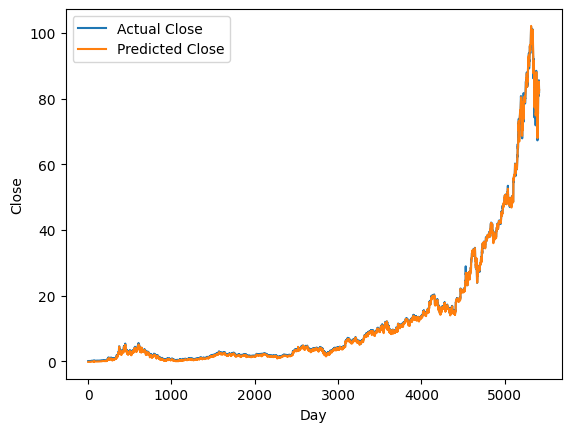

In [400]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [401]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((X_test.shape[0], 5))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 83.2921619 ,  83.93452404,  82.32115742, ..., 169.26100678,
       169.57173577, 170.10142953])

In [402]:
dummies = np.zeros((X_test.shape[0], 5))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 83.52500086,  82.17949711,  81.56349814, ..., 184.89999997,
       184.07000412, 187.06000405])

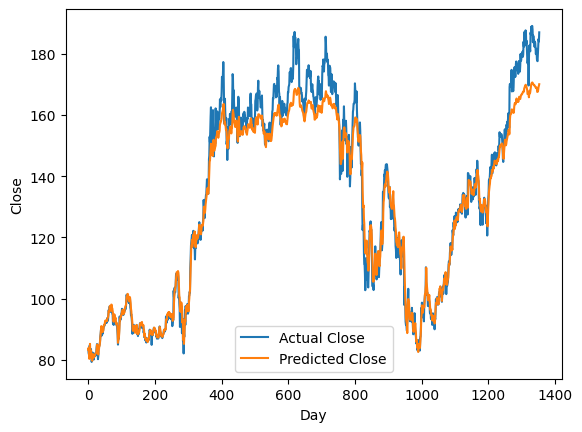

In [403]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()